# Learning Cross-Product using pytorch

The purpose of this project is to use PyTorch outside the context of neural networks. The task here is to train a model that will compute cross product of two three-dimensional vectors. The objective of this exercise is to explore the "pythonic" aspect of PyTorch.

We model the cross product as a tensor-mediated product $ c_i = \epsilon_{ijk}a_jb_k$. The tensor $\epsilon$ is a trainable parameter of the model, and we expect it to match the Levi-Civita tensor.

## Supervised learning
In this simple model, we will feed pairs of vectors and then verify that they are truly cross products. The loss function checks how much the predicted vector is different from the actual cross product


In [1]:
import torch
from matplotlib import pyplot as plt
from torch.nn import Parameter
from torch.optim import SGD

4.906782535840648e-09


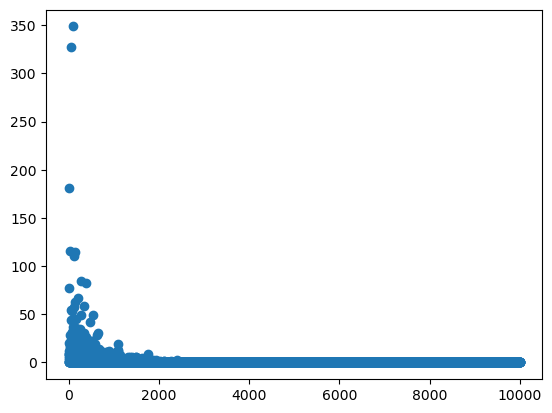

In [2]:
ep = Parameter(torch.randn(3,3,3), requires_grad=True)

opt = SGD(params=(ep,),lr=1E-3)
losses = []
n_steps = 10_000
for step in range(n_steps):
    a = torch.randn(3)
    b = torch.randn(3)
    c = torch.cross(a,b)
    prediction = torch.einsum("ijk,j,k->i", ep, a, b)
    loss = torch.dot(c - prediction, c - prediction)/2
    losses.append(loss.item())
    loss.backward()
    opt.step()
    opt.zero_grad()
# print(ep)
plt.scatter(x=range(n_steps), y=losses)
print(losses[-1])

In [3]:
print(ep)

Parameter containing:
tensor([[[ 1.0955e-05,  2.9630e-05, -3.7728e-05],
         [ 1.4276e-05,  8.8082e-05,  9.9998e-01],
         [-9.9078e-06, -1.0000e+00,  1.8971e-05]],

        [[ 8.3094e-06,  1.7124e-06, -9.9999e-01],
         [ 2.7287e-05, -1.4629e-05, -1.5764e-05],
         [ 9.9996e-01, -3.1703e-05, -3.2365e-06]],

        [[ 2.5212e-05,  9.9996e-01,  2.0671e-05],
         [-9.9997e-01, -3.3963e-05,  1.0797e-05],
         [-3.0542e-05,  3.7616e-05, -6.0207e-05]]], requires_grad=True)


## Training the model using properties of the cross product
In the previous section, we used supervised learning to learn Levi-Civita tensor and cross product of three-dimensional vectors. In this section, wee will traing the model using properties of cross product, rather than comparing the predicted vector with the actual cross product. Here we will make the model satisfy three criteria:
1. The cross product operation is antisymmetric, i.e. $\vec{a} \times \vec{b} + \vec{b} \times \vec{a} = 0$
2. It is normalized, that is the length of $\vec{e_1} \times \vec{e_2}, \vec{e_1} \times \vec{e_3}, \vec{e_2} \times \vec{e_3}$ are all equals to one.
3. The cross product is orthogonal to both terms, i.e. dot product is zero: $(\vec{a} \times \vec{b}) \cdot \vec{a} = 0$ and $(\vec{a} \times \vec{b}) \cdot \vec{b} = 0$
These criteria are still not sufficient to guaarantee that we learn correctly the cross-product function, because it is possible that we instead learn negative cross-product. In other words, the model will produce either $\epsilon$ or $-\epsilon$

1.2659466847253498e-05


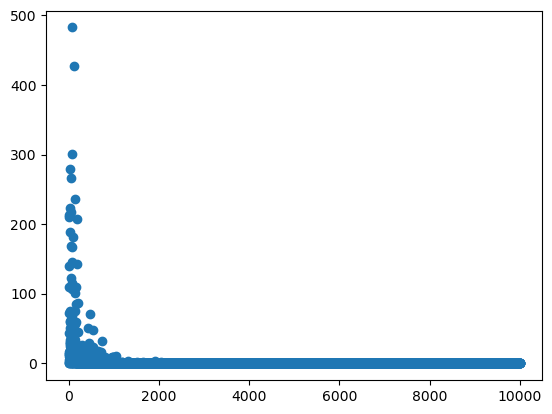

In [13]:
ep = Parameter(torch.randn(3,3,3), requires_grad=True)

opt = SGD(params=(ep,),lr=1E-3)
losses = []
n_steps = 10_000
e1 = torch.tensor([1.0, 0.0, 0.0])
e2 = torch.tensor([0.0, 1.0, 0.0])
e3 = torch.tensor([0.0, 0.0, 1.0])
for step in range(n_steps):
    a = torch.randn(3)
    b = torch.randn(3)
    p1 = torch.einsum("ijk,j,k->i", ep, a, b)
    p2 = torch.einsum("ijk,j,k->i", ep, b, a)
    p_sum = p1 + p2
    p_prod_a = torch.dot(p1, a)
    p_prod_b = torch.dot(p1, b)
    p12 = torch.einsum("ijk,j,k->i", ep, e1, e2)
    p13 = torch.einsum("ijk,j,k->i", ep, e1, e3)
    p23 = torch.einsum("ijk,j,k->i", ep, e2, e3)
    loss = torch.dot(p_sum, p_sum)/2 + \
           (1-torch.dot(p12, p12))**2/6 + \
           (1-torch.dot(p13, p13))**2/6 + \
           (1-torch.dot(p23, p23))**2/6 + (p_prod_a ** 2 + p_prod_b ** 2) / 4
    losses.append(loss.item())
    loss.backward()
    opt.step()
    opt.zero_grad()
# print(ep)
plt.scatter(x=range(n_steps), y=losses)
print(losses[-1])

In [14]:
ep

Parameter containing:
tensor([[[-1.5880e-05,  4.7683e-05,  5.3528e-05],
         [-4.6085e-07,  4.7272e-05, -9.9767e-01],
         [-2.9965e-05,  9.9688e-01, -4.0021e-05]],

        [[-4.0523e-05,  1.7235e-05,  9.9770e-01],
         [-3.0135e-07, -1.1027e-05, -6.7566e-05],
         [-9.9676e-01,  1.5644e-05,  5.9592e-05]],

        [[-7.9570e-06, -9.9768e-01, -1.1900e-05],
         [ 9.9689e-01, -4.3567e-05, -3.2372e-05],
         [-7.1624e-06,  3.8180e-05,  6.8536e-05]]], requires_grad=True)

In [15]:
t1 = torch.tensor([2.0, 3.0, 9.5])
t2 = torch.tensor([-9.0, 0.0, 1.75])
print(torch.einsum("ijk,j,k->i", ep, t1, t2))
print(torch.cross(t1, t2))

tensor([ -5.2354,  88.7160, -26.9144], grad_fn=<ViewBackward0>)
tensor([  5.2500, -89.0000,  27.0000])


We can see that we indeed learned negative cross product. This is a metter of convention that $\vec{e_1} \times \vec{e_2} = \vec{e_3}$ and not $- \vec{e_3}$

## Conclusion
This notebook is a PyTorch tutorial with  goal of training a model to predict cross product of two vectors in a 3-dimensional vector space. Further work maay include finding a cross-product in a vector space with more than three dimensions, and also creating a Layer that does a cross-product.